In [24]:
import os
import glob
import json
import torch
import pickle
import numpy as np
import os.path as osp
from torch_geometric.data import Data, InMemoryDataset
import traceback


def undirected_graph(data):
    """
    A pre_transform function that transfers the directed graph into undirected graph.
    Args:
        data (torch_geometric.data.Data): Directed graph in the format :class:`torch_geometric.data.Data`.
        where the :obj:`data.x`, :obj:`data.edge_index` are required.
    """
    data.edge_index = torch.cat(
        [torch.stack([data.edge_index[1], data.edge_index[0]], dim=0), data.edge_index],
        dim=1,
    )
    return data


def split(data, batch):
    # i-th contains elements from slice[i] to slice[i+1]
    node_slice = torch.cumsum(torch.from_numpy(np.bincount(batch)), 0)
    node_slice = torch.cat([torch.tensor([0]), node_slice])
    row, _ = data.edge_index
    edge_slice = torch.cumsum(torch.from_numpy(np.bincount(batch[row])), 0)
    edge_slice = torch.cat([torch.tensor([0]), edge_slice])

    # Edge indices should start at zero for every graph.
    data.edge_index -= node_slice[batch[row]].unsqueeze(0)
    data.__num_nodes__ = np.bincount(batch).tolist()

    slices = dict()
    slices["x"] = node_slice
    slices["edge_index"] = edge_slice
    slices["y"] = torch.arange(0, batch[-1] + 2, dtype=torch.long)
    return data, slices


def read_file(folder, prefix, name):
    file_path = osp.join(folder, prefix + f"_{name}.txt")
    return np.genfromtxt(file_path, dtype=np.int64)


def read_sentigraph_data(folder: str, prefix: str):
    txt_files = glob.glob(os.path.join(folder, "{}_*.txt".format(prefix)))
    json_files = glob.glob(os.path.join(folder, "{}_*.json".format(prefix)))
    txt_names = [f.split(os.sep)[-1][len(prefix) + 1 : -4] for f in txt_files]
    json_names = [f.split(os.sep)[-1][len(prefix) + 1 : -5] for f in json_files]
    names = txt_names + json_names

    with open(os.path.join(folder, prefix + "_node_features.pkl"), "rb") as f:
        x: np.array = pickle.load(f)
    x: torch.FloatTensor = torch.from_numpy(x)
    edge_index: np.array = read_file(folder, prefix, "edge_index")
    edge_index: torch.tensor = torch.tensor(edge_index, dtype=torch.long).T
    batch: np.array = read_file(folder, prefix, "node_indicator") - 1  # from zero
    y: np.array = read_file(folder, prefix, "graph_labels")
    y: torch.tensor = torch.tensor(y, dtype=torch.long)

    supplement = dict()
    if "split_indices" in names:
        split_indices: np.array = read_file(folder, prefix, "split_indices")
        split_indices = torch.tensor(split_indices, dtype=torch.long)
        supplement["split_indices"] = split_indices
    if "sentence_tokens" in names:
        with open(os.path.join(folder, prefix + "_sentence_tokens.json")) as f:
            sentence_tokens: dict = json.load(f)
        supplement["sentence_tokens"] = sentence_tokens

    data = Data(x=x, edge_index=edge_index, y=y)
    data, slices = split(data, batch)

    return data, slices, supplement


class SentiGraphDataset(InMemoryDataset):
    r"""
    The SentiGraph datasets from `Explainability in Graph Neural Networks: A Taxonomic Survey
    <https://arxiv.org/abs/2012.15445>`_.
    The datasets take pretrained BERT as node feature extractor
    and dependency tree as edges to transfer the text sentiment datasets into
    graph classification datasets.

    The dataset `Graph-SST2 <https://drive.google.com/file/d/1-PiLsjepzT8AboGMYLdVHmmXPpgR8eK1/view?usp=sharing>`_
    should be downloaded to the proper directory before running. All the three datasets Graph-SST2, Graph-SST5, and
    Graph-Twitter can be download in this
    `link <https://drive.google.com/drive/folders/1dt0aGMBvCEUYzaG00TYu1D03GPO7305z?usp=sharing>`_.

    Args:
        root (:obj:`str`): Root directory where the datasets are saved
        name (:obj:`str`): The name of the datasets.
        transform (:obj:`Callable`, :obj:`None`): A function/transform that takes in an
            :class:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (:obj:`Callable`, :obj:`None`):  A function/transform that takes in
            an :class:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)

    .. note:: The default parameter of pre_transform is :func:`~undirected_graph`
        which transfers the directed graph in original data into undirected graph before
        being saved to disk.
    """

    def __init__(self, root, name, transform=None, pre_transform=undirected_graph):
        self.name = name
        super(SentiGraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices, self.supplement = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self):
        return osp.join(self.root, self.name, "raw")

    @property
    def processed_dir(self):
        return osp.join(self.root, self.name, "processed")

    @property
    def raw_file_names(self):
        return [
            "node_features",
            "node_indicator",
            "sentence_tokens",
            "edge_index",
            "graph_labels",
            "split_indices",
        ]

    @property
    def processed_file_names(self):
        return ["data.pt"]

    def process(self):
        # Read data into huge `Data` list.
        try:
            self.data, self.slices, self.supplement = read_sentigraph_data(
                self.raw_dir, self.name
            )
        except Exception as e:
            print(e)
            print(traceback.format_exc())
            if type(e) is FileNotFoundError:
                print(
                    "Please download the required datasets file to the root directory."
                )
                print(
                    "The google drive link is "
                    "https://drive.google.com/drive/folders/1dt0aGMBvCEUYzaG00TYu1D03GPO7305z?usp=sharing"
                )
            raise SystemExit()

        if self.pre_filter is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [data for data in data_list if self.pre_filter(data)]
            self.data, self.slices = self.collate(data_list)

        if self.pre_transform is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [self.pre_transform(data) for data in data_list]
            self.data, self.slices = self.collate(data_list)
        torch.save((self.data, self.slices, self.supplement), self.processed_paths[0])


dataset = SentiGraphDataset(root=".", name="Graph-SST2")

/var/folders/st/cyh3v8ln22sdswp1s386w5vw0000gn/T/ipykernel_76596/4262463046.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices, self.supplement = t

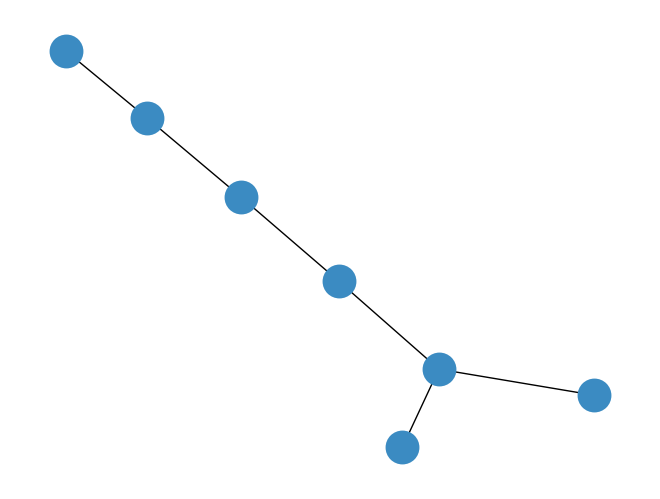

In [25]:
from custom.utils import *

plot_graph(dataset[0])

Total number of graphs: 70042
Number of classes: 2
Number of node features: 768
Average number of nodes per graph: 10
Max number of nodes in a graph: 56
Min number of nodes in a graph: 1
Class distribution:
 - Class 0: 31120 graphs (44.43%)
 - Class 1: 38922 graphs (55.57%)


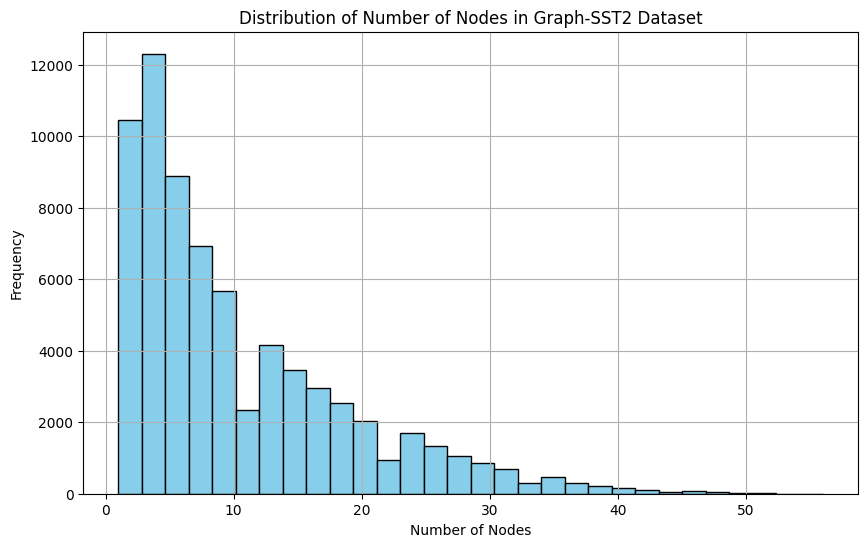

Small graphs: 59674
Medium graphs: 10368
Large graphs: 0


([Data(x=[7, 768], edge_index=[2, 12], y=[1]),
  Data(x=[7, 768], edge_index=[2, 12], y=[1]),
  Data(x=[12, 768], edge_index=[2, 22], y=[1]),
  Data(x=[8, 768], edge_index=[2, 14], y=[1]),
  Data(x=[16, 768], edge_index=[2, 30], y=[1]),
  Data(x=[10, 768], edge_index=[2, 18], y=[1]),
  Data(x=[2, 768], edge_index=[2, 2], y=[1]),
  Data(x=[10, 768], edge_index=[2, 18], y=[1]),
  Data(x=[14, 768], edge_index=[2, 26], y=[1]),
  Data(x=[4, 768], edge_index=[2, 6], y=[1]),
  Data(x=[17, 768], edge_index=[2, 32], y=[1]),
  Data(x=[7, 768], edge_index=[2, 12], y=[1]),
  Data(x=[6, 768], edge_index=[2, 10], y=[1]),
  Data(x=[7, 768], edge_index=[2, 12], y=[1]),
  Data(x=[3, 768], edge_index=[2, 4], y=[1]),
  Data(x=[2, 768], edge_index=[2, 2], y=[1]),
  Data(x=[6, 768], edge_index=[2, 10], y=[1]),
  Data(x=[2, 768], edge_index=[2, 2], y=[1]),
  Data(x=[10, 768], edge_index=[2, 18], y=[1]),
  Data(x=[5, 768], edge_index=[2, 8], y=[1]),
  Data(x=[7, 768], edge_index=[2, 12], y=[1]),
  Data(x=[5,

In [26]:
analyze_dataset(dataset)

In [27]:
import random
import torch
import numpy as np
from torch_geometric.data import Data
import torch_geometric


def add_noise_to_graph(graph, num_new_nodes, avg_new_edges_per_node=2):
    num_nodes = graph.num_nodes

    new_edges_list = []
    for new_node_id in range(num_nodes, num_nodes + num_new_nodes):
        connections = np.random.choice(num_nodes, avg_new_edges_per_node, replace=False)
        for conn in connections:
            new_edges_list.append([new_node_id, conn])
            new_edges_list.append([conn, new_node_id])

    new_edges = torch.tensor(new_edges_list, dtype=torch.long).t()
    new_edge_index = torch.cat([graph.edge_index, new_edges], dim=1)

    new_node_features = torch.randn(num_new_nodes, graph.x.size(1))

    graph.x = torch.cat([graph.x, new_node_features], dim=0)
    graph.edge_index = new_edge_index
    graph.num_nodes += num_new_nodes

    return graph


def remove_nodes_from_graph(graph, num_remove):
    nodes_to_remove = random.sample(range(graph.num_nodes), num_remove)

    mask = torch.ones(graph.num_nodes, dtype=torch.bool)
    mask[nodes_to_remove] = False

    new_idx = torch.arange(graph.num_nodes)[mask]
    idx_map = {
        int(old_idx): int(new_idx_idx) for new_idx_idx, old_idx in enumerate(new_idx)
    }

    new_edge_index = []
    for u, v in graph.edge_index.t():
        u = int(u)
        v = int(v)
        if u in idx_map and v in idx_map:
            new_edge_index.append([idx_map[u], idx_map[v]])

    graph.edge_index = torch.tensor(new_edge_index, dtype=torch.long).t().contiguous()
    graph.x = graph.x[mask]
    graph.num_nodes = graph.x.size(0)

    return graph


def perturb_graph(graph, num_remove=2, num_add=3, avg_new_edges_per_node=2):
    if graph.num_nodes > num_remove:
        graph = remove_nodes_from_graph(graph, num_remove)

    graph = add_noise_to_graph(
        graph, num_add, avg_new_edges_per_node=avg_new_edges_per_node
    )

    original_node_types = torch.ones(graph.num_nodes - num_add, dtype=torch.long)
    noise_node_types = torch.zeros(num_add, dtype=torch.long)
    graph.node_type = torch.cat([original_node_types, noise_node_types], dim=0)

    node_degrees = torch_geometric.utils.degree(
        graph.edge_index[0], num_nodes=graph.num_nodes
    )

    return graph


def perturb_prototypes(prototypes, num_remove=2, num_add=3, avg_new_edges_per_node=2):
    perturbed_prototypes = []
    for proto in prototypes:
        perturbed_proto = perturb_graph(
            proto.clone(),
            num_remove=num_remove,
            num_add=num_add,
            avg_new_edges_per_node=avg_new_edges_per_node,
        )
        perturbed_prototypes.append(perturbed_proto)

    return perturbed_prototypes

In [28]:
def plot_perturbed_graph(graph, node_type_attr="node_type"):
    G = to_networkx(graph, to_undirected=True)

    if hasattr(graph, node_type_attr):
        node_types = getattr(graph, node_type_attr).tolist()

        if len(node_types) != graph.num_nodes:
            raise ValueError(
                f"Mismatch between node types ({len(node_types)}) and number of nodes ({graph.num_nodes})"
            )

        color_map = ["blue" if node_type == 1 else "red" for node_type in node_types]
    else:
        color_map = ["blue"] * graph.num_nodes

    plt.figure(figsize=(8, 8))
    nx.draw(
        G,
        node_color=color_map,
        with_labels=True,
        node_size=500,
        font_color="white",
    )
    plt.show()

In [29]:
def sample_prototypes(dataset, num_prototypes=5, min_num_nodes=10):
    prototypes = []
    class_labels = dataset.data.y.unique().tolist()
    for label in class_labels:
        class_graphs = [
            graph
            for graph in dataset
            if graph.y.item() == label and graph.num_nodes > min_num_nodes
        ]
        sampled_prototypes = random.sample(class_graphs, num_prototypes)
        prototypes.extend(sampled_prototypes)
    return prototypes

Data(x=[16, 768], edge_index=[2, 30], y=[1])


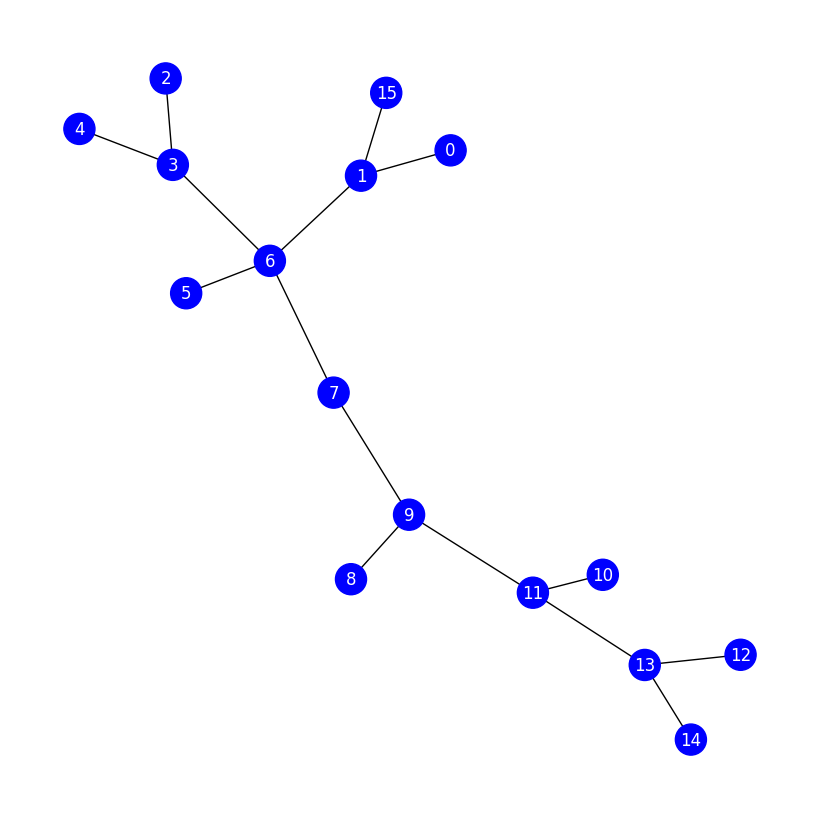

Data(x=[16, 768], edge_index=[2, 30], y=[1])


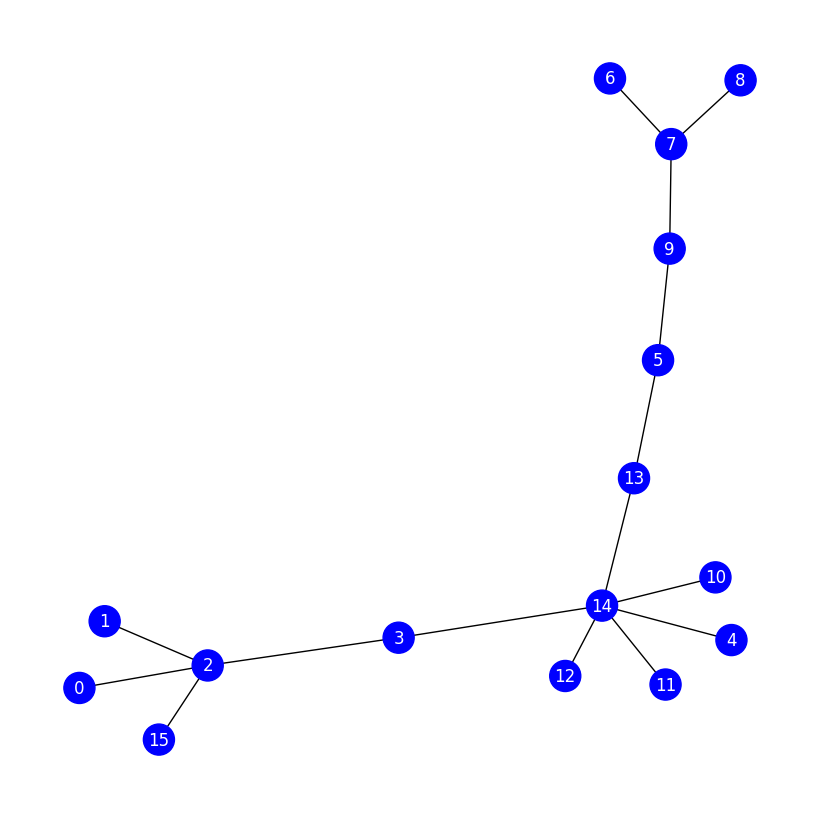

Data(x=[15, 768], edge_index=[2, 28], y=[1])


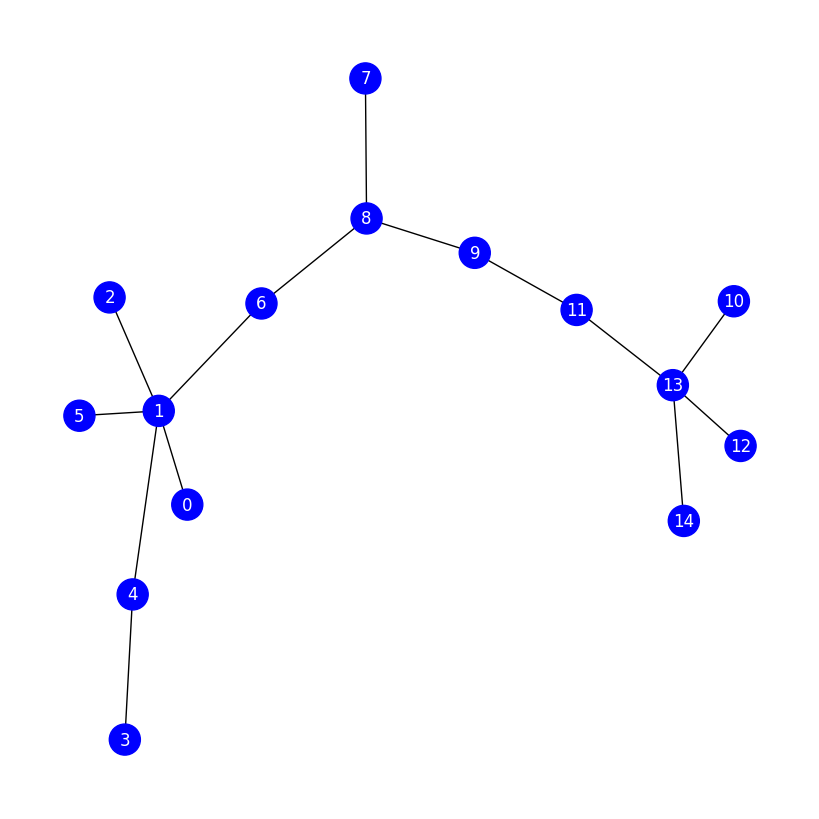

Data(x=[13, 768], edge_index=[2, 24], y=[1])


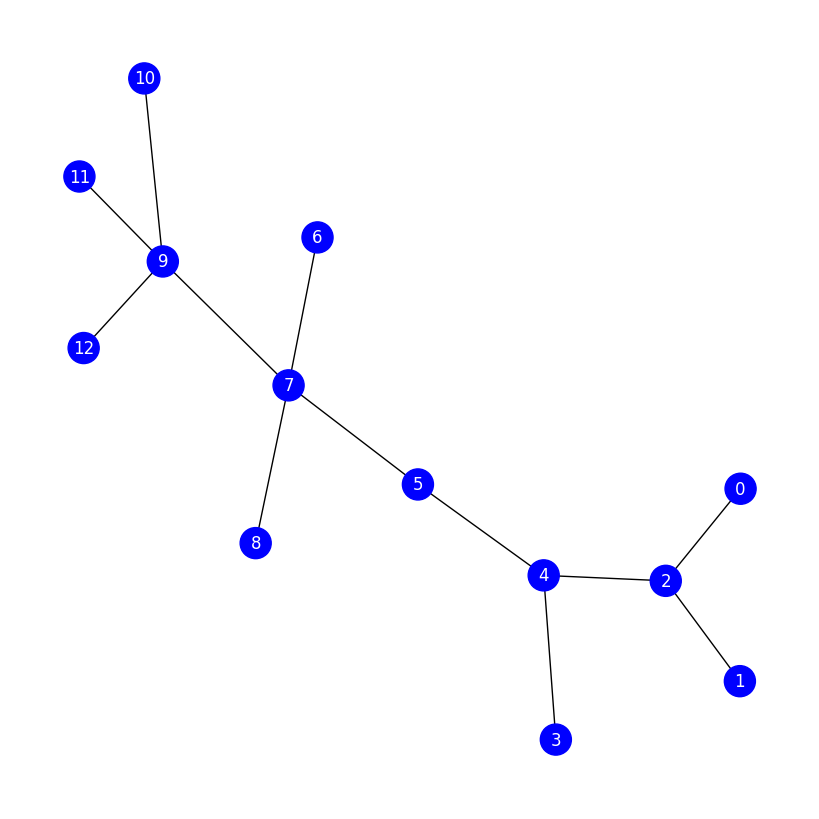

Data(x=[19, 768], edge_index=[2, 36], y=[1])


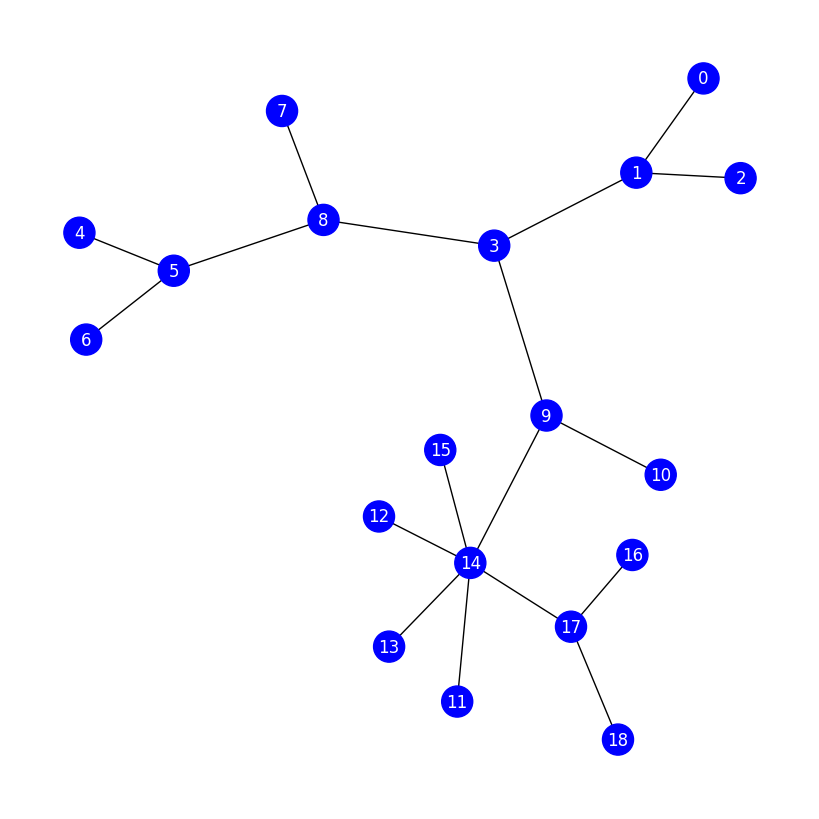

Data(x=[21, 768], edge_index=[2, 40], y=[1])


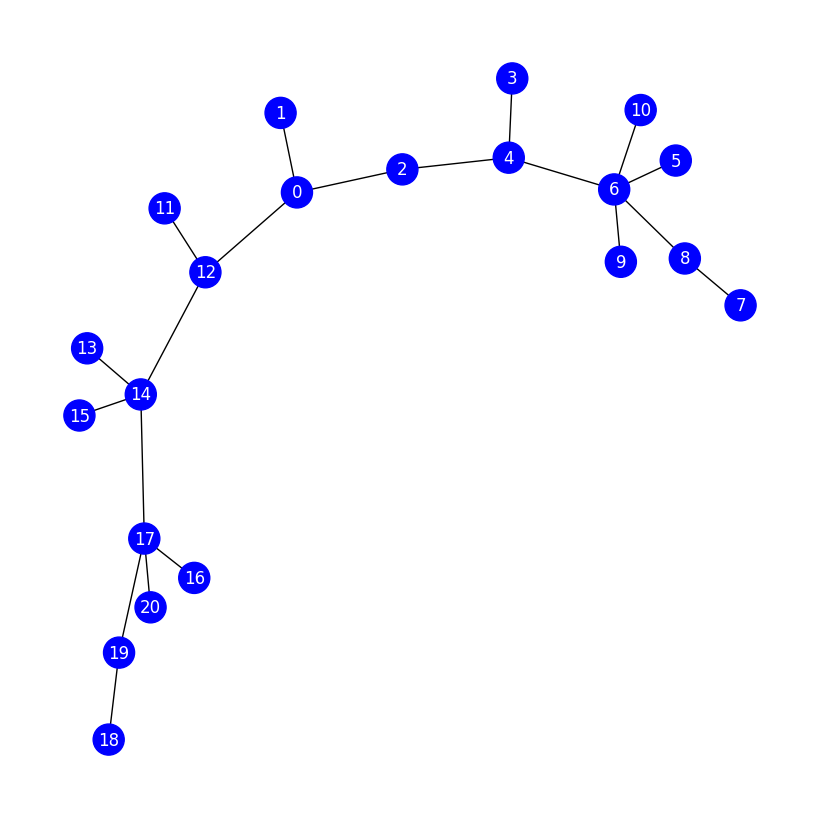

Data(x=[13, 768], edge_index=[2, 24], y=[1])


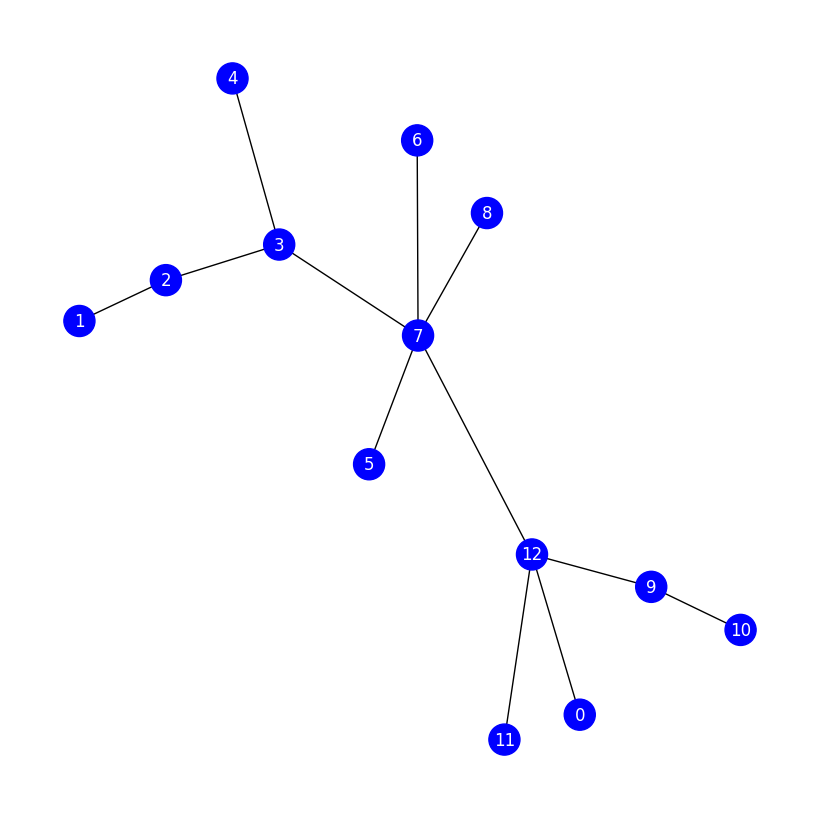

Data(x=[27, 768], edge_index=[2, 52], y=[1])


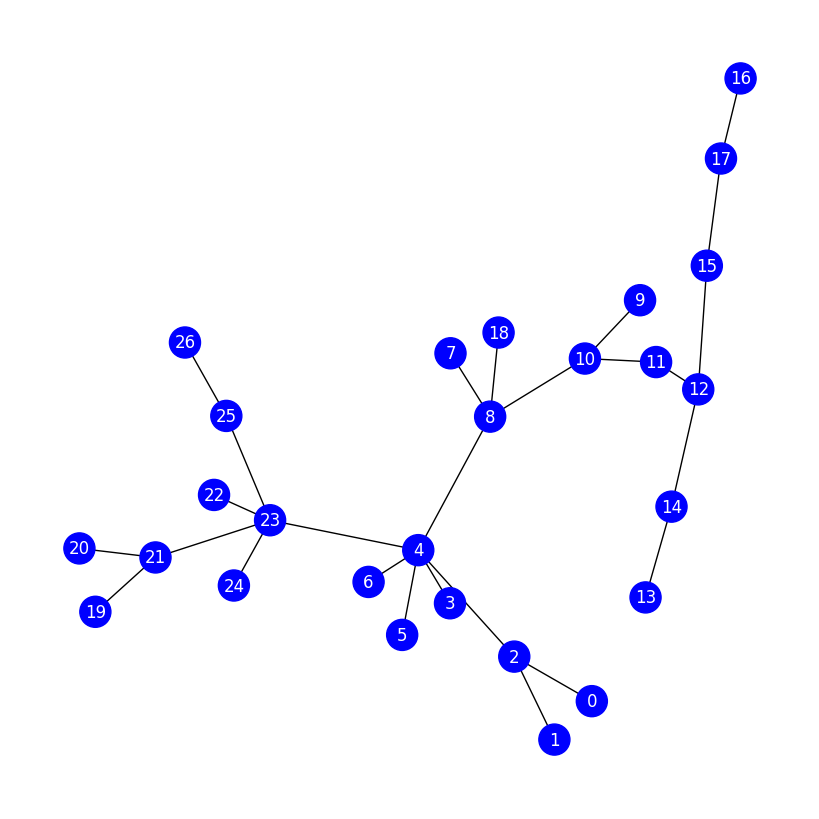

Data(x=[21, 768], edge_index=[2, 40], y=[1])


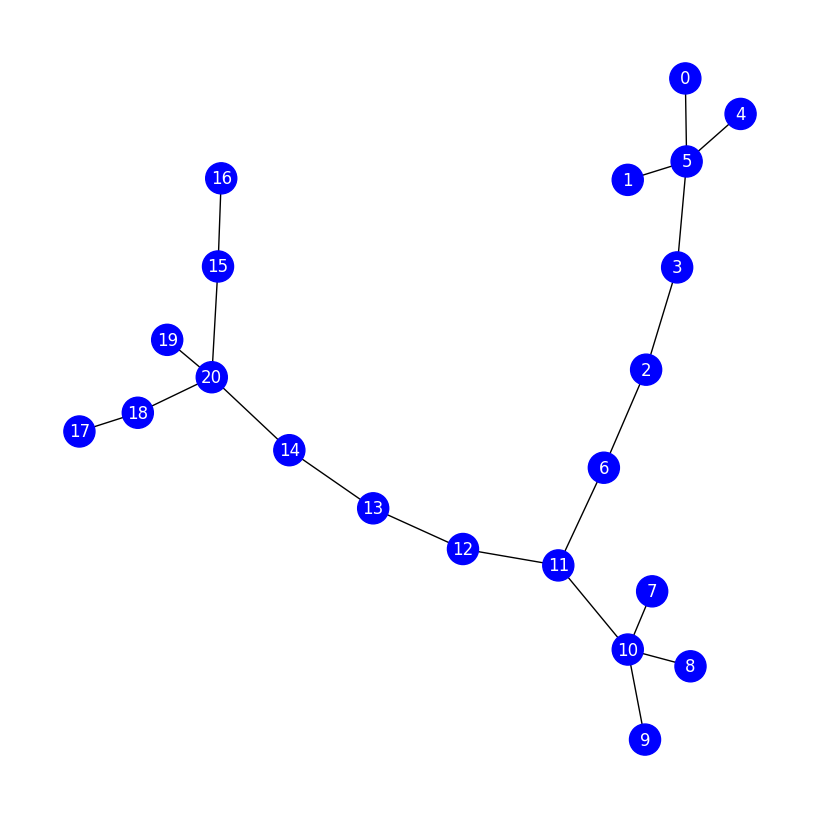

Data(x=[31, 768], edge_index=[2, 60], y=[1])


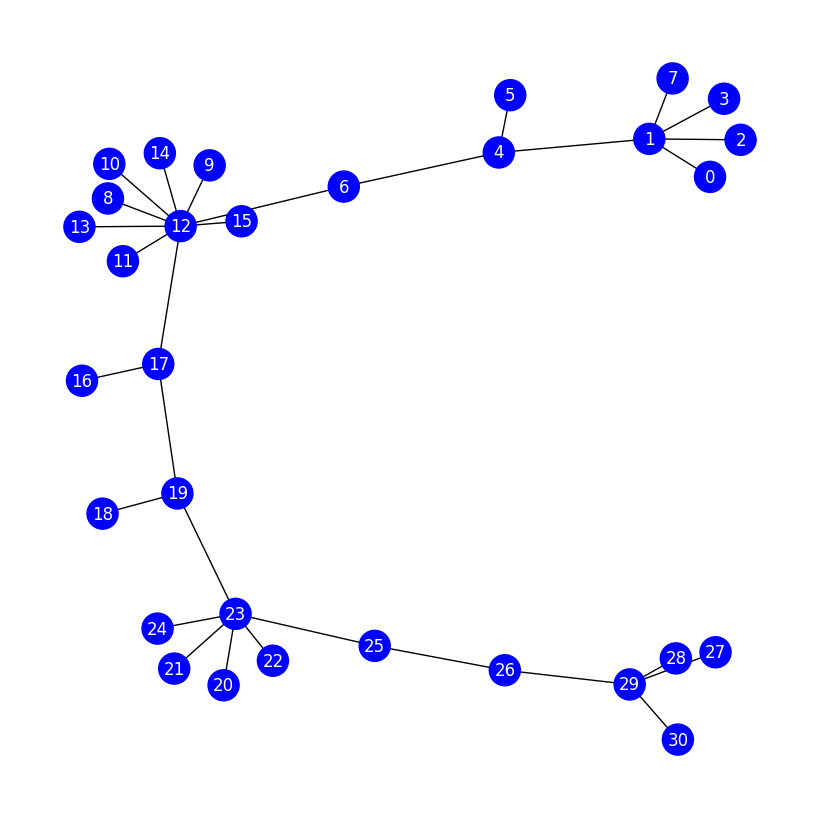

In [31]:
prototypes = sample_prototypes(dataset, num_prototypes=5, min_num_nodes=10)
perturbed_prototypes = perturb_prototypes(prototypes, num_remove=2, num_add=3)


for g in prototypes:
    print(g)
    plot_perturbed_graph(g)